In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn

import random
from deap import base, creator, tools, algorithms

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

wDr = os.getcwd()

## Define Model

In [2]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [3]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initilaise the model
forward_model = SimpleMLP(5, 2).to(device)

# Load the saved model weights
forward_model.load_state_dict(torch.load(r"C:\Users\anish\PhD\Bumper_simulation_gold\ML\ML_gold\Active learning\forward_model_weights_5000_iteration0.pth"))

# Evaluate each model
forward_model.eval()

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

## Performance evaluation

In [4]:
concatenated_df = pd.read_csv(r"C:\Users\anish\PhD\Bumper_simulation_gold\ML\ML_gold\Active learning\best_top_optimized_new\Data_iteration0.csv")
#concatenated_df.set_index(['index'], inplace = True)
concatenated_df.drop('Unnamed: 0', axis = 1, inplace = True)
#concatenated_df = concatenated_df[-35:]
concatenated_df

,theta_min,theta_max,t_min,t_max,velocity,Peak Stress (MPa),Strain Energy Density (MPa)
0,0.9332,1.4822,2.59153,0.99390,0.0,0.74977,0.13977
1,1.5665,1.5472,2.29930,1.08162,0.0,0.34869,0.07186
2,1.0963,1.2488,1.36207,2.24614,0.0,0.38119,0.12755
3,1.3223,0.8613,1.01014,2.59830,0.0,0.70156,0.15535
4,1.3342,1.0808,1.45496,2.13960,0.0,0.36792,0.12347
...,...,...,...,...,...,...,...
6085,1.1908,0.9231,2.10032,1.51611,1.0,1.83001,0.47132
6086,1.3304,0.8149,1.46473,2.11912,1.0,3.32030,0.50955
6087,1.0111,0.9108,2.76858,0.87142,1.0,1.82495,0.44099
6088,1.0867,1.1061,1.02041,2.61912,1.0,4.37206,0.46279


In [5]:
X = concatenated_df.iloc[:, :5].values
Y = concatenated_df.iloc[:, 5:].values

In [6]:
X

array([[0.9332 , 1.4822 , 2.59153, 0.9939 , 0.     ],
       [1.5665 , 1.5472 , 2.2993 , 1.08162, 0.     ],
       [1.0963 , 1.2488 , 1.36207, 2.24614, 0.     ],
       ...,
       [1.0111 , 0.9108 , 2.76858, 0.87142, 1.     ],
       [1.0867 , 1.1061 , 1.02041, 2.61912, 1.     ],
       [1.0918 , 1.2442 , 1.41492, 2.19372, 1.     ]])

In [7]:
df = pd.DataFrame()
df['PS'] = Y[:, 0]
df['SED'] = Y[:, 1]
df['theta_min'] = X[:, 0]
df['theta_max'] = X[:, 1]
df['t_min'] = X[:, 2]
df['t_max'] = X[:, 3]
df['velocity'] = X[:, 4]
df = df.round(6)
#df['velocity'].unique()

df['sigma_minus_U'] = df['PS'] - 10*df['SED']
df.sort_values('sigma_minus_U', inplace=True)
df

,PS,SED,theta_min,theta_max,t_min,t_max,velocity,sigma_minus_U
5480,1.87997,0.49216,1.3399,0.9615,2.22312,1.37075,1.0,-3.04163
5282,1.87951,0.48780,1.2180,0.8305,2.62818,0.99031,1.0,-2.99849
5315,2.01759,0.50129,0.8625,0.9070,2.77658,0.83576,1.0,-2.99531
6074,1.78722,0.47474,0.8436,0.9568,2.58402,1.02236,1.0,-2.96018
5653,1.89321,0.48494,0.7863,0.8790,1.99867,1.56029,1.0,-2.95619
...,...,...,...,...,...,...,...,...
5796,4.85362,0.43781,1.3002,0.9544,0.68577,2.95419,1.0,0.47552
5654,5.28750,0.46621,1.5128,1.3594,1.98781,1.47978,1.0,0.62540
5972,5.30720,0.46478,1.0884,1.2640,2.13758,1.46997,1.0,0.65940
5237,5.74422,0.49790,1.1254,1.5677,0.84107,2.66220,1.0,0.76522


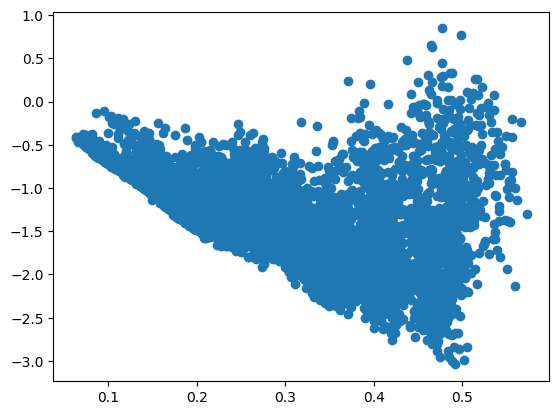

In [8]:
plt.scatter(df['SED'], df['sigma_minus_U'])

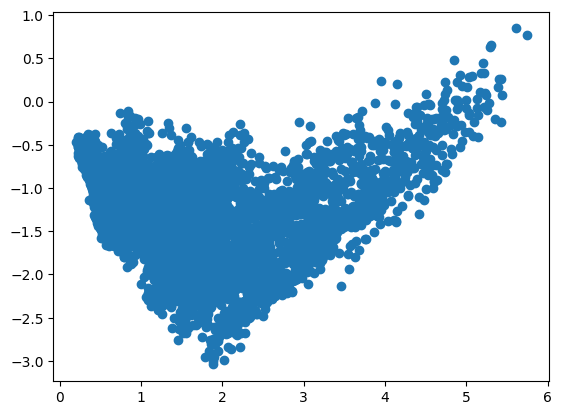

In [9]:
plt.scatter(df['PS'], df['sigma_minus_U'])

In [ ]:
df_prime = df.groupby('t_min').sum().round(5)
df_prime = df_prime.sort_values(['sigma_minus_U'])
df_prime.reset_index(inplace= True)
df_prime = df_prime[['PS', 'SED', 'theta_min', 'theta_max', 't_min', 't_max', 'velocity', 'sigma_minus_U']]
df_prime = df_prime.iloc[:50]
df_prime

,PS,SED,theta_min,theta_max,t_min,t_max,velocity,sigma_minus_U
0,7.80372,2.20342,6.3301,6.7018,2.15087,10.21790,3.41379,-14.23048
1,8.71835,2.28499,5.5041,6.1530,1.99867,10.92203,3.41379,-14.13155
2,8.73034,2.26745,5.6700,6.7081,1.94471,11.47846,3.41379,-13.94416
3,8.78046,2.26330,5.6329,7.3164,2.09705,10.47648,3.41379,-13.85254
4,8.06707,2.18021,6.9965,7.3801,2.39931,8.64283,3.41379,-13.73503
...,...,...,...,...,...,...,...,...
95,8.53416,2.03357,8.5260,5.8135,2.62818,6.93217,3.41379,-11.80154
96,10.01515,2.18156,5.5867,9.7811,2.51118,7.48811,3.41379,-11.80045
97,8.91794,2.07177,8.6261,7.4396,1.88737,12.06191,3.41379,-11.79976
98,8.93822,2.07341,8.8774,7.4627,2.41776,8.34736,3.41379,-11.79588


In [11]:
# Given ordered column values
ordered_values = df_prime['t_min']

# Sort DataFrame based on the order of values in column 'B'
df_sorted = df.set_index('t_min').loc[ordered_values].reset_index()

df_sorted = df_sorted[df_sorted['velocity'] == 1]

# Define the desired column order
column_order = ['PS', 'SED', 'theta_min', 'theta_max', 't_min', 't_max', 'velocity', 'sigma_minus_U']

# Reorder the columns
df = df_sorted[column_order]
df

,PS,SED,theta_min,theta_max,t_min,t_max,velocity,sigma_minus_U
0,2.04673,0.47305,0.9043,0.9574,2.15087,1.45970,1.0,-2.68377
7,1.89321,0.48494,0.7863,0.8790,1.99867,1.56029,1.0,-2.95619
14,1.94865,0.47222,0.8100,0.9583,1.94471,1.63978,1.0,-2.77355
21,2.27599,0.48293,0.8047,1.0452,2.09705,1.49664,1.0,-2.55331
28,1.95632,0.46447,0.9995,1.0543,2.39931,1.23469,1.0,-2.68838
...,...,...,...,...,...,...,...,...
665,1.87951,0.48780,1.2180,0.8305,2.62818,0.99031,1.0,-2.99849
672,2.47866,0.47762,0.7981,1.3973,2.51118,1.06973,1.0,-2.29754
680,2.50264,0.47040,1.2323,1.0628,1.88737,1.72313,1.0,-2.20136
686,2.16222,0.47373,1.2682,1.0661,2.41776,1.19248,1.0,-2.57508


## GA

#### Fix relative density

In [12]:
# Independant parameters
Platelength_X = 150.0
Platelength_Y = 100.0
type1 = 2
height = 2

# Dependant parameters
L = Platelength_X/type1/5
B = Platelength_Y/type1/2

LHS = 1153

In [13]:
# Define your analytical expression
def analytical_expression(theta_min, theta_max, t_min, t_max):
    
    #t = torch.linspace(t_min, t_max, 2*type1 + 1)
    #theta = torch.linspace(theta_min, theta_max, 2*type1)

    steps = 2*type1 + 1
    index = torch.arange(steps, dtype=torch.float32).to(device)
    step_size = (t_max - t_min) / (steps - 1)
    t = t_min + step_size * index

    steps = 2*type1
    index = torch.arange(steps, dtype=torch.float32).to(device)
    step_size = (theta_max - theta_min) / (steps - 1)
    theta = theta_min + step_size * index

    RHS = 0
    for i in range(len(t) - 1):  
        #t_inside = torch.linspace(t[i], t[i+1], 4)

        steps = 4
        index = torch.arange(steps, dtype=torch.float32).to(device)
        step_size = (t[i+1] - t[i]) / (steps - 1)
        t_inside = t[i] + step_size * index

        tan_alpha = (2 - torch.abs(torch.cos(theta[i])))/torch.sin(theta[i])
        
        RHS += torch.abs(torch.cos(theta[i]))/(4 * torch.sin(theta[i])) * ((L - t_inside[1])**2 + (L - t_inside[2])**2 + (L - t[i])**2 + (L - t[i+1])**2) + height * ((L - t[i]) + (L - t[i+1])) + 0.5 * ((L - t_inside[1]) + (L - t_inside[2])) * (B - 2*height - torch.abs(torch.cos(theta[i]))/(2*torch.sin(theta[i])) * ((L - t_inside[1]) + (L - t_inside[2])) - tan_alpha * (t_inside[1]/2 + t_inside[2]/2))

    return RHS

# Define the objective function
def rho_objective(params, target_value):

    theta_min = params[0]
    theta_max = params[1]
    t_min = params[2]
    t_max = params[3]

    return abs(analytical_expression(theta_min, theta_max, t_min, t_max) - target_value)

#### Run

c:\Users\anish\anaconda3\envs\venv0\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\anish\anaconda3\envs\venv0\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


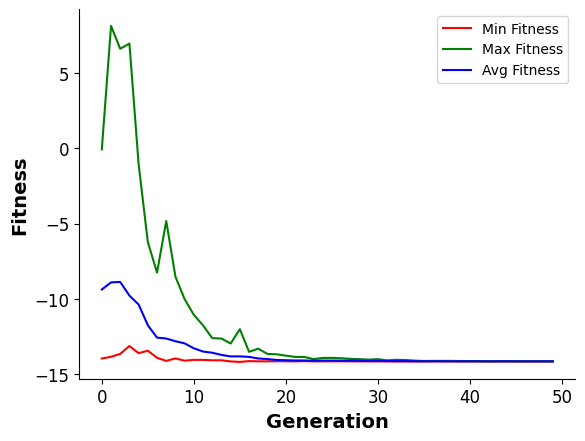

In [14]:
PS_pred, SED_pred = 0, 0
good = []

while len(good) < 5:
    # Define upper and lower bounds for lattice parameters
    lower_bounds = [np.pi/4, np.pi/4, 0.5, 0.5]  # Lower bounds for each parameter
    upper_bounds = [np.pi/2, np.pi/2, 3, 3]  # Upper bounds for each parameter



    # Step 1: Create the fitness function and individual
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimization problem (minimizing the difference)
    creator.create("Individual", list, fitness=creator.FitnessMin)




    # Step 2: Initialize population and individual with 4 parameters from DataFrame, respecting bounds
    def create_individual(index):
        #individual = list(df.iloc[index, 2:6].round(6))  # Select lattice parameters from columns 3 to 6
        individual = list(df.iloc[index, 2:6].round(6))  # Select lattice parameters from columns 3 to 6
        return individual

    toolbox = base.Toolbox()
    #toolbox.register("individual", tools.initIterate, creator.Individual, lambda: create_individual(index))
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: create_individual(random.randint(0, len(df)-1)))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)




    # Step 3: Define evaluation function (difference between the first two columns)
    def evaluate(individual):
        # Find the index in the DataFrame that corresponds to the individual (assuming exact match)
        v1 = torch.tensor([0], dtype=torch.float32).to(device)
        v2 = torch.tensor([0.137931], dtype=torch.float32).to(device)
        v3 = torch.tensor([0.310345], dtype=torch.float32).to(device)
        v4 = torch.tensor([0.482759], dtype=torch.float32).to(device)
        v5 = torch.tensor([0.655172], dtype=torch.float32).to(device)
        v6 = torch.tensor([0.827586], dtype=torch.float32).to(device)
        v7 = torch.tensor([1], dtype=torch.float32).to(device)

        lattice_params = torch.tensor(individual, dtype=torch.float32).to(device)
        #lattice_params = torch.clamp(lattice_params, torch.tensor(lower_bounds, dtype = torch.float32).to(device), torch.tensor(upper_bounds, dtype = torch.float32).to(device))
        #print(lattice_params)

        tensor1 = torch.concat((lattice_params, v1))
        tensor2 = torch.concat((lattice_params, v2))
        tensor3 = torch.concat((lattice_params, v3))
        tensor4 = torch.concat((lattice_params, v4))
        tensor5 = torch.concat((lattice_params, v5))
        tensor6 = torch.concat((lattice_params, v6))
        tensor7 = torch.concat((lattice_params, v7))
        
        outputs1 = forward_model(tensor1).detach().cpu().numpy()
        outputs2 = forward_model(tensor2).detach().cpu().numpy()
        outputs3 = forward_model(tensor3).detach().cpu().numpy()
        outputs4 = forward_model(tensor4).detach().cpu().numpy()
        outputs5 = forward_model(tensor5).detach().cpu().numpy()
        outputs6 = forward_model(tensor6).detach().cpu().numpy()
        outputs7 = forward_model(tensor7).detach().cpu().numpy()

        return (outputs1[0] - 10*outputs1[1] + outputs2[0] - 10*outputs2[1] + outputs3[0] - 10*outputs3[1] + outputs4[0] - 10*outputs4[1] +
                    outputs5[0] - 10*outputs5[1] + outputs6[0] - 10*outputs6[1] + outputs7[0] - 10*outputs7[1] + rho_objective(lattice_params, LHS),)




    # Step 4: Define bounded mutation to keep individuals within bounds
    def bounded_mutate(individual, mu, sigma, indpb):
        for i in range(len(individual)):
            if random.random() < indpb:
                individual[i] += random.gauss(mu, sigma)
                # Apply bounds to each parameter
                individual[i] = min(max(individual[i], lower_bounds[i]), upper_bounds[i])
        return individual,

    def apply_bounds(individual, lower_bounds, upper_bounds):
        return [min(max(ind, lb), ub) for ind, lb, ub in zip(individual, lower_bounds, upper_bounds)]

    def crossover_and_clamp(ind1, ind2, alpha=0.5):
        tools.cxBlend(ind1, ind2, alpha)
        ind1[:] = apply_bounds(ind1, lower_bounds, upper_bounds)
        ind2[:] = apply_bounds(ind2, lower_bounds, upper_bounds)
        return ind1, ind2




    # Step 5: Register genetic operators
    #toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
    toolbox.register("mate", crossover_and_clamp)
    toolbox.register("mutate", bounded_mutate, mu=0, sigma=0.2, indpb=0.2)  # Bounded mutation
    toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection
    toolbox.register("evaluate", evaluate)




    # Step 6: Define genetic algorithm parameters
    population_size = 50  # Size of the population
    num_generations = 50  # Number of generations
    cx_prob = 0.9  # Crossover probability
    mut_prob = 0 #0.2  # Mutation probability




    # Step 7: Run the Genetic Algorithm

    # Initialize population
    #population = toolbox.population(n=population_size)
    population = [creator.Individual(create_individual(i)) for i in range(len(df))]

    # Statistics to track progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda pop: sum(fitness[0] for fitness in pop) / len(pop))
    stats.register("min", lambda pop: min(fitness[0] for fitness in pop))
    stats.register("max", lambda pop: max(fitness[0] for fitness in pop))

    # Run the genetic algorithm
    #population, logbook = algorithms.eaSimple(population, toolbox, cxpb=cx_prob, mutpb=mut_prob,
        #                                           ngen=num_generations, stats=stats, verbose=True)


    # Custom loop to store best individual each generation
    best_individuals_per_gen = []

    # Initialize lists to store fitness values for each generation
    min_fitness_values = []
    max_fitness_values = []
    avg_fitness_values = []

    for gen in range(num_generations):

        # Perform one generation
        offspring = algorithms.varAnd(population, toolbox, cxpb=cx_prob, mutpb=mut_prob)
        fits = list(map(toolbox.evaluate, offspring))
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Select the next generation population
        population = toolbox.select(offspring, k=len(population))

        # Calculate fitness statistics
        min_fitness = min(ind.fitness.values[0].cpu() for ind in population)
        max_fitness = max(ind.fitness.values[0].cpu() for ind in population)
        avg_fitness = sum(ind.fitness.values[0].cpu() for ind in population) / len(population)

        # Store fitness statistics for plotting later
        min_fitness_values.append(min_fitness)
        max_fitness_values.append(max_fitness)
        avg_fitness_values.append(avg_fitness)

        # Get the best individual of the current generation
        best_individual = tools.selBest(population, k=1)[0]
        best_individuals_per_gen.append(best_individual)

        # Print best individual and fitness
        #print(f"Generation {gen}: Best Individual = {best_individual}, Fitness = {best_individual.fitness.values[0]}")

    # Save the best individuals from each generation
    best_individuals_df = pd.DataFrame([list(ind) for ind in best_individuals_per_gen])
    best_individuals_df.to_csv("best_individuals_per_gen" + str(gen) + ".csv", index=False)


    # Output the best individual found
    best_individual = tools.selBest(population, k=10)

    optimized_params = pd.DataFrame(np.array(best_individual))

    lattice_params = torch.tensor(best_individual, dtype=torch.float32).to(device)

    good.append(lattice_params)

# Plot the fitness values for each generation
fig, ax = plt.subplots()
#plt.figure(figsize=(10, 6))

# Adjust tick font sizes
ax.tick_params(axis='both', which='major', labelsize=12)  # Change fontsize for major ticks
ax.tick_params(axis='both', which='minor', labelsize=10)  # Optional: Change fontsize for minor ticks

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.plot(range(num_generations), min_fitness_values, label="Min Fitness", color='red')
plt.plot(range(num_generations), max_fitness_values, label="Max Fitness", color='green')
plt.plot(range(num_generations), avg_fitness_values, label="Avg Fitness", color='blue')
plt.xlabel("Generation", fontsize = 14, fontweight='bold')
plt.ylabel("Fitness", fontsize = 14, fontweight='bold')
#plt.title("Fitness Evolution Over Generations")
plt.legend()
#plt.grid(True)
plt.show()

In [15]:
PS_pred1, SED_pred1, PS_pred2, SED_pred2, PS_pred3, SED_pred3, PS_pred4, SED_pred4, PS_pred5, SED_pred5, PS_pred6, SED_pred6, PS_pred7, SED_pred7 = [], [], [], [], [], [], [], [], [], [], [], [], [], []


for lattice in good:
    for lat in lattice:
        forward_model.eval()

        v1 = torch.tensor([0], dtype=torch.float32).to(device)
        v2 = torch.tensor([0.137931], dtype=torch.float32).to(device)
        v3 = torch.tensor([0.310345], dtype=torch.float32).to(device)
        v4 = torch.tensor([0.482759], dtype=torch.float32).to(device)
        v5 = torch.tensor([0.655172], dtype=torch.float32).to(device)
        v6 = torch.tensor([0.827586], dtype=torch.float32).to(device)
        v7 = torch.tensor([1], dtype=torch.float32).to(device)

        lattice_params = torch.tensor(lat, dtype=torch.float32).to(device)

        tensor1 = torch.concat((lattice_params, v1))
        tensor2 = torch.concat((lattice_params, v2))
        tensor3 = torch.concat((lattice_params, v3))
        tensor4 = torch.concat((lattice_params, v4))
        tensor5 = torch.concat((lattice_params, v5))
        tensor6 = torch.concat((lattice_params, v6))
        tensor7 = torch.concat((lattice_params, v7))
        
        PS1, SED1 = forward_model(tensor1)
        PS2, SED2 = forward_model(tensor2)
        PS3, SED3 = forward_model(tensor3)
        PS4, SED4 = forward_model(tensor4)
        PS5, SED5 = forward_model(tensor5)
        PS6, SED6 = forward_model(tensor6)
        PS7, SED7 = forward_model(tensor7)

        PS_pred1.append(PS1.detach().cpu().numpy())
        SED_pred1.append(SED1.detach().cpu().numpy())

        PS_pred2.append(PS2.detach().cpu().numpy())
        SED_pred2.append(SED2.detach().cpu().numpy())

        PS_pred3.append(PS3.detach().cpu().numpy())
        SED_pred3.append(SED3.detach().cpu().numpy())

        PS_pred4.append(PS4.detach().cpu().numpy())
        SED_pred4.append(SED4.detach().cpu().numpy())

        PS_pred5.append(PS5.detach().cpu().numpy())
        SED_pred5.append(SED5.detach().cpu().numpy())

        PS_pred6.append(PS6.detach().cpu().numpy())
        SED_pred6.append(SED6.detach().cpu().numpy())

        PS_pred7.append(PS7.detach().cpu().numpy())
        SED_pred7.append(SED7.detach().cpu().numpy())
        #print(PS, SED)

C:\Users\anish\AppData\Local\Temp\ipykernel_8384\4206968060.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lattice_params = torch.tensor(lat, dtype=torch.float32).to(device)


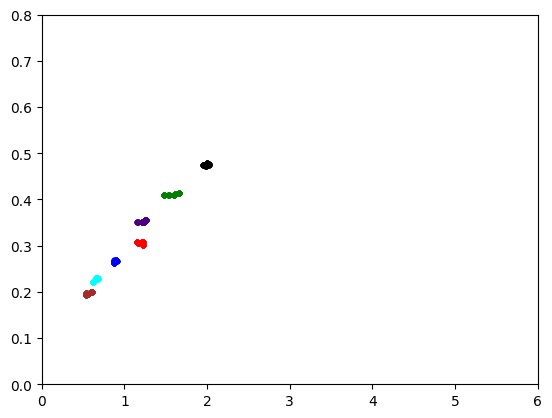

In [16]:
plt.scatter(PS_pred1, SED_pred1, s=10, color = 'brown')
plt.scatter(PS_pred2, SED_pred2, s=10, color = 'cyan')
plt.scatter(PS_pred3, SED_pred3, s=10, color = 'blue')
plt.scatter(PS_pred4, SED_pred4, s=10, color = 'red')
plt.scatter(PS_pred5, SED_pred5, s=10, color = 'indigo')
plt.scatter(PS_pred6, SED_pred6, s=10, color = 'green')
plt.scatter(PS_pred7, SED_pred7, s=10, color = 'black')

plt.xlim(0, 6)
plt.ylim(0, 0.8)
#plt.legend(['v = 15', 'v = 20', 'v = 25'])
#plt.savefig('optimized1_dynamic.png', transparent = True)
plt.show()

In [17]:
for i in range(len(good)):
    good[i] = good[i].cpu().numpy()

In [18]:
reshaped_list = [arr[0].reshape(4) for arr in good]
reshaped_list

[array([0.8036021, 0.9458696, 2.1283   , 1.4528736], dtype=float32),
 array([0.84751225, 0.96794605, 2.07293   , 1.524816  ], dtype=float32),
 array([0.78606045, 0.97712994, 2.1698306 , 1.4104803 ], dtype=float32),
 array([0.7854199 , 0.96421814, 2.0497544 , 1.5274153 ], dtype=float32),
 array([0.785567  , 0.97490925, 2.0127325 , 1.5660864 ], dtype=float32)]

In [20]:
optimized_params = optimized_params.drop_duplicates(subset=[0, 1, 2, 3])
optimized_params

,0,1,2,3
0,0.803602,0.945870,2.128300,1.452874
1,0.847512,0.967946,2.072930,1.524816
2,0.786060,0.977130,2.169831,1.410480
3,0.785420,0.964218,2.049754,1.527415
4,0.785567,0.974909,2.012733,1.566086


In [ ]:
#optimized_params.to_csv('gradient_optimized_structures_multi_speed_Dynamic_iteration0.csv', header = None, index = None)